# Simple sequence imitation with hyperparameter tuning

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

import gymnasium as gym
from gymnasium.spaces import Dict, Box, Discrete

from stable_baselines3 import DQN, PPO, A2C
# from sb3_contrib import TRPO, CrossQ, ARS, QRDQN, TQC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

import optuna

import os
import time
import pickle
import sys
sys.path.append('../environments')
from environments import *

# Simulate data

In [4]:
env_name = 'SimpleTel-v0'

OUTDIR = f'results/{env_name}/'
if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)
    
SEED = 20

In [5]:
Nf = 20
nv_max = 3
random.seed(2)
true_sequence = np.array([np.full(nv_max, i) for i in range(Nf)]).flatten()
true_sequence = true_sequence.tolist()
random.shuffle(true_sequence)
print(true_sequence)

[16, 10, 13, 3, 5, 19, 2, 6, 12, 10, 14, 8, 13, 9, 2, 1, 6, 11, 7, 0, 7, 2, 8, 11, 19, 16, 15, 4, 16, 4, 3, 0, 14, 5, 15, 9, 11, 19, 10, 8, 13, 9, 17, 12, 0, 17, 4, 12, 5, 6, 14, 15, 3, 17, 7, 18, 1, 1, 18, 18]


# Set up environment

In [8]:
# Register the environment so we can create it with gym.make()
gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=ToyEnv_v0,
    max_episode_steps=300,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)

In [9]:
env = gym.make(f"gymnasium_env/{env_name}", Nf=Nf, target_sequence=true_sequence, nv_max=nv_max, off_by_lim=3)
# Create multiple environments for parallel training
# vec_env = gym.make_vec("gymnasium_env/SimpleTel-v0", num_envs=5, vectorization_mode='sync', Nf=Nf, target_sequence=true_sequence, nv_max=nv_max)


In [10]:
from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env.unwrapped)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment passes all checks!


## How does model do with no training?

In [13]:
model_kwargs = {'policy': "MultiInputPolicy", "env": env, "verbose": True}
models = {'A2C': A2C, 'DQN':DQN, 'PPO':PPO} 
results = {model_name: {'model': model(**model_kwargs)} for model_name, model in models.items()}
results

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


{'A2C': {'model': <stable_baselines3.a2c.a2c.A2C at 0x732c4e1cb610>},
 'DQN': {'model': <stable_baselines3.dqn.dqn.DQN at 0x732c44be3580>},
 'PPO': {'model': <stable_baselines3.ppo.ppo.PPO at 0x732c4e1cb3d0>}}

In [14]:
observation_list = np.empty(shape=(3, len(true_sequence)), dtype=dict)
reward_list = np.empty_like(observation_list)
terminated_list = np.empty_like(observation_list)
truncated_list = np.empty_like(observation_list)
info_list = np.empty_like(observation_list, dtype=dict)

In [15]:
for j, (name, model_dict) in enumerate(results.items()):
    obs, info = env.reset(seed=SEED)
    observation_list[j, 0] = obs
    info_list[j, 0] = info
    for i in range(len(true_sequence)):
        action, _states = model_dict['model'].predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action.tolist())
        observation_list[j,i+1] = obs
        info_list[j, i+1] = info
        reward_list[j, i] = reward
        terminated_list[j, i] = terminated
        truncated_list[j, i] = truncated
        if terminated or truncated:
            print(i)
            break

58
58
58


In [16]:

for j, obs_list in enumerate(observation_list):
    proposed_survey = [observation_list[j, i]['field_id'] for i in range(len(observation_list[j]))]
    print(proposed_survey)

[16, 1, 1, 19, 14, 1, 1, 1, 1, 1, 1, 1, 14, 1, 1, 14, 14, 1, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 11, 8, 8, 0, 11, 11, 8, 8, 8, 8]
[16, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 11, 4, 4, 4, 4, 11, 11, 4, 4, 4, 11, 4, 11, 4, 4, 11, 11, 4, 4, 11, 11, 4, 4, 11, 4, 11, 4, 4, 4, 11, 11, 11, 11, 4, 4, 4, 11, 11, 4, 4, 11, 11, 4]
[16, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 5, 6, 6, 6, 11, 6, 11, 19, 19, 19, 11, 19, 19, 19, 11, 19, 19, 19, 19, 19, 19, 19, 12, 11, 19, 19, 19, 12, 12, 12, 19, 12, 19, 19, 19, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]


In [17]:
print(true_sequence)

[16, 10, 13, 3, 5, 19, 2, 6, 12, 10, 14, 8, 13, 9, 2, 1, 6, 11, 7, 0, 7, 2, 8, 11, 19, 16, 15, 4, 16, 4, 3, 0, 14, 5, 15, 9, 11, 19, 10, 8, 13, 9, 17, 12, 0, 17, 4, 12, 5, 6, 14, 15, 3, 17, 7, 18, 1, 1, 18, 18]


## Now train and predict

In [18]:
for name in results.keys():
    file_path = OUTDIR + env_name + f'-Nf={Nf}-vmax={nv_max}_{name}'
    try:
        results[name]['model'] = results[name]['model'].load(file_path, env=env)
    except:
        t_start = time.time()
        results[name]['model'].learn(total_timesteps=100_000, log_interval=10)
        t_stop = time.time()
        results[name]['train_time'] = t_stop - t_start
        results[name]['model'].save(path=file_path)
        

------------------------------------
| time/                 |          |
|    fps                | 559      |
|    iterations         | 10       |
|    time_elapsed       | 0        |
|    total_timesteps    | 50       |
| train/                |          |
|    entropy_loss       | -2.92    |
|    explained_variance | -0.416   |
|    learning_rate      | 0.0007   |
|    n_updates          | 9        |
|    policy_loss        | 0.275    |
|    value_loss         | 0.00993  |
------------------------------------


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 59       |
|    ep_rew_mean        | 2.4      |
| time/                 |          |
|    fps                | 560      |
|    iterations         | 20       |
|    time_elapsed       | 0        |
|    total_timesteps    | 100      |
| train/                |          |
|    entropy_loss       | -2.9     |
|    explained_variance | -1.21    |
|    learning_rate      | 0.0007   |
|    n_updates          | 19       |
|    policy_loss        | -0.155   |
|    value_loss         | 0.00858  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 59       |
|    ep_rew_mean        | 2.7      |
| time/                 |          |
|    fps                | 591      |
|    iterations         | 30       |
|    time_elapsed       | 0        |
|    total_timesteps    | 150      |
| train/                |          |
|

In [19]:
observation_list = np.empty(shape=(3, len(true_sequence)), dtype=dict)
reward_list = np.empty_like(observation_list)
terminated_list = np.empty_like(observation_list)
truncated_list = np.empty_like(observation_list)
info_list = np.empty_like(observation_list, dtype=dict)

In [20]:
for j, (name, model_dict) in enumerate(results.items()):
    obs, info = env.reset(seed=SEED)
    observation_list[j, 0] = obs
    info_list[j, 0] = info
    for i in range(len(true_sequence)):
        action, _states = results[name]['model'].predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action.tolist())
        observation_list[j,i+1] = obs
        info_list[j, i+1] = info
        reward_list[j, i] = reward
        terminated_list[j, i] = terminated
        truncated_list[j, i] = truncated
        if terminated or truncated:
            print(i)
            break

58
58
58


In [21]:
proposed_survey = np.empty_like(observation_list)
for j, obs_list in enumerate(observation_list):
    proposed_survey[j] = [observation_list[j, i]['field_id'] for i in range(len(observation_list[j]))]


In [ ]:
print(proposed_survey)

[[16 13 13 3 5 13 13 6 13 13 13 13 13 13 13 13 6 13 13 13 13 13 13 13 13
  16 13 13 16 13 3 13 13 5 13 13 13 13 13 13 13 13 13 13 13 13 13 13 5 6
  13 13 3 16 13 16 13 13 16 13]
 [16 10 13 3 5 19 2 6 12 10 14 6 13 9 2 1 6 11 7 0 7 2 11 11 19 16 15 4
  16 4 3 0 14 5 15 9 11 19 10 6 13 9 17 12 0 17 4 12 5 6 14 15 3 17 7 18
  1 1 18 18]
 [16 10 13 3 5 19 2 6 12 10 14 8 13 9 2 1 6 11 7 0 7 2 8 11 17 15 15 4 15
  4 3 0 14 5 15 9 11 17 10 8 13 9 17 12 3 17 4 12 5 6 14 15 3 17 7 18 1 1
  18 18]]


In [22]:
print(true_sequence)

[16, 10, 13, 3, 5, 19, 2, 6, 12, 10, 14, 8, 13, 9, 2, 1, 6, 11, 7, 0, 7, 2, 8, 11, 19, 16, 15, 4, 16, 4, 3, 0, 14, 5, 15, 9, 11, 19, 10, 8, 13, 9, 17, 12, 0, 17, 4, 12, 5, 6, 14, 15, 3, 17, 7, 18, 1, 1, 18, 18]


/tmp/ipykernel_67607/289756295.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,i].legend()


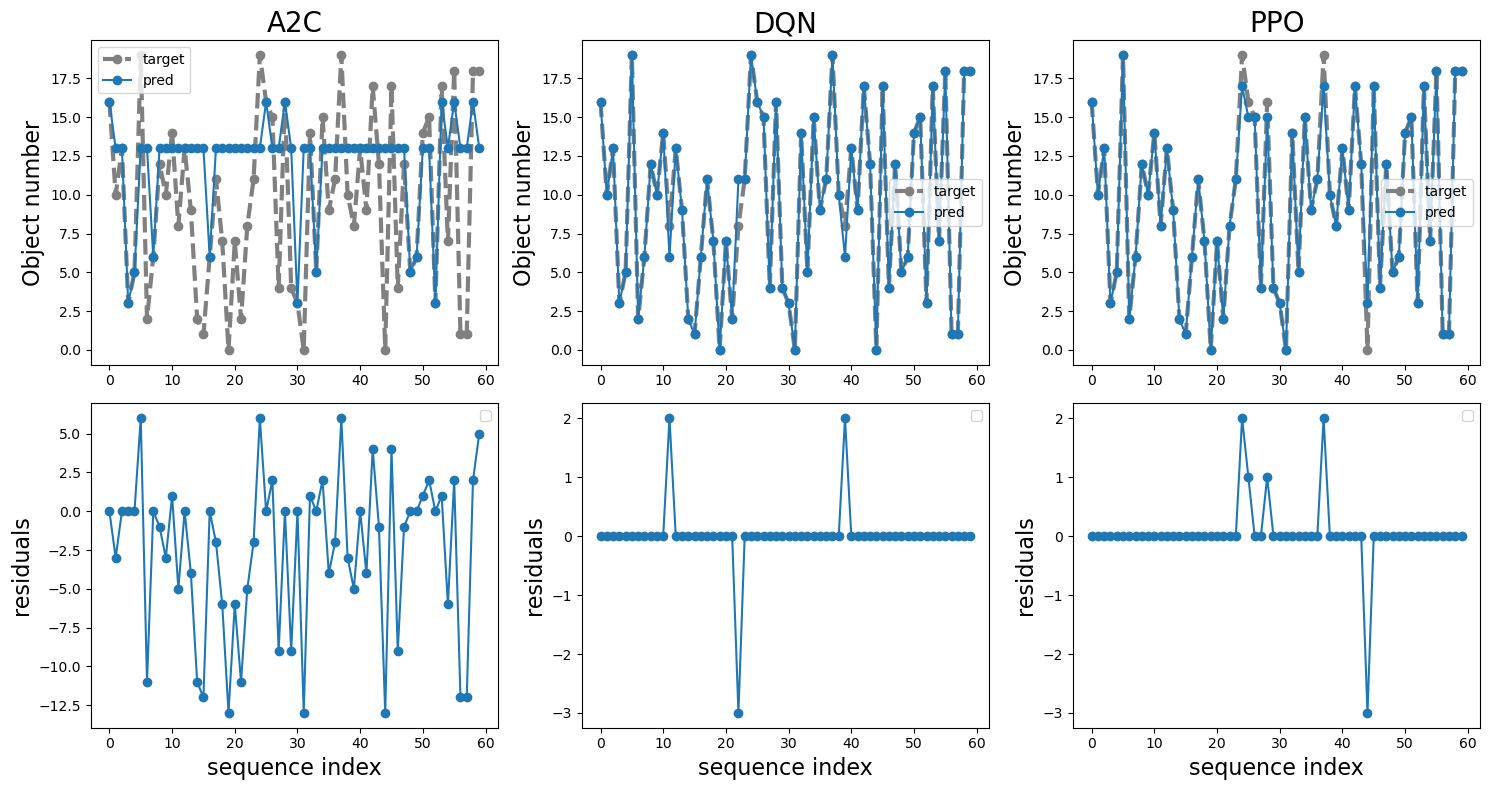

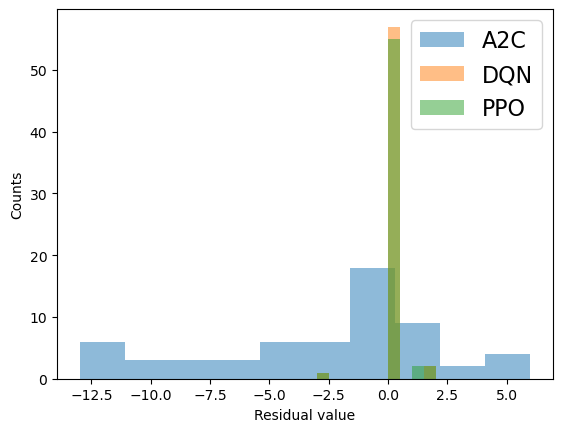

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(15,8), sharex='row')
fig_hist, ax_hist = plt.subplots()
for i, model_name in enumerate(results.keys()):
    axs[0,i].set_title(model_name, fontsize=20)
    axs[0,i].plot(np.array(true_sequence), marker='o', label='target', color='grey', linestyle='dashed', lw=3)
    axs[0,i].plot(np.array(proposed_survey[i]), marker='o', label='pred')
    axs[0,i].legend()
    axs[0,i].set_ylabel('Object number', fontsize=16)

    residuals = np.array(true_sequence) - np.array(proposed_survey[i])
    axs[1,i].plot(residuals, marker='o')
    axs[1,i].legend()
    axs[1, i].set_xlabel('sequence index', fontsize=16)
    axs[1,i].set_ylabel('residuals', fontsize=16)
    
    ax_hist.hist(residuals, label=model_name, alpha=.5)
    ax_hist.set_xlabel('Residual value')
    ax_hist.set_ylabel('Counts')
    ax_hist.legend(fontsize=16)
fig.tight_layout()
    
# fig.savefig(OUTDIR + '')

In [20]:
n_episodes = 50
rewards = np.empty(shape=(len(true_sequence), n_episodes))
for i, model_name in enumerate(results.keys()):
    mean, std = evaluate_policy(results[model_name]['model'], Monitor(env), n_eval_episodes=n_episodes, deterministic=False)
    rewards[i], epsiodes = evaluate_policy(results[model_name]['model'], Monitor(env), n_eval_episodes=n_episodes, return_episode_rewards=True, deterministic=False)
    print(model_name, "mean =", f"{mean:.2f}", ', std = ', f"{std:.2f}")

A2C mean = 15.78 , std =  0.14
DQN mean = 53.43 , std =  1.41
PPO mean = 48.78 , std =  2.30


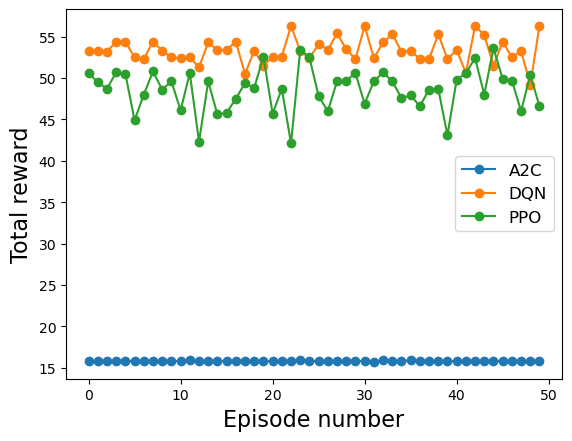

In [21]:
for i, model_name in enumerate(results.keys()):
    plt.plot(rewards[i], label=model_name, marker='o')
plt.xlabel('Episode number', fontsize=16)
plt.ylabel('Total reward', fontsize=16)
plt.legend(fontsize=12)

# Hyperparameter tuning

In [23]:
def A2C_objective(trial):
    # hyperparam bounds
    learning_rate = trial.suggest_loguniform('learning_rate', 2e-4, 2e-3) # lr = 7e-4
    gamma = trial.suggest_uniform('gamma', 0.95, 0.9999) # gamma=.99
    # entropy_coef = trial.suggest_loguniform('entropy_coef', 1e-5, 0.1)
    
    # Define env
    env = gym.make(f"gymnasium_env/{env_name}", Nf=Nf, target_sequence=true_sequence, nv_max=nv_max, off_by_lim=3)

    # Create the model with suggested hyperparameters
    model = A2C(policy="MultiInputPolicy", env=Monitor(env), learning_rate=learning_rate, gamma=gamma, verbose=0)
    
    # Train the model
    model.learn(total_timesteps=10_000)
    
    # Evaluate the model
    mean_reward, _ = evaluate_policy(model, Monitor(env), deterministic=False, n_eval_episodes=10)
    
    return mean_reward

def PPO_objective(trial):
    # hyperparam bounds
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-3) # lr = 3e-4
    gamma = trial.suggest_uniform('gamma', 0.95, 0.9999)
    # clip_range = trial.suggest_uniform('clip_range', 0.1, 0.3)
    # n_epochs = trial.suggest_int('n_epochs', 3, 20)
    
    # Define env
    env = gym.make(f"gymnasium_env/{env_name}", Nf=Nf, target_sequence=true_sequence, nv_max=nv_max, off_by_lim=3)

    # Create the model with suggested hyperparameters
    model = PPO(policy="MultiInputPolicy", env=Monitor(env), learning_rate=learning_rate, gamma=gamma, verbose=0)
    
    # Train the model
    model.learn(total_timesteps=10_000)
    
    # Evaluate the model
    mean_reward, _ = evaluate_policy(model, Monitor(env), deterministic=False, n_eval_episodes=10)
    
    return mean_reward

def DQN_objective(trial):
    # hyperparam bounds
    learning_rate = trial.suggest_loguniform('learning_rate', 5e-5, 5e-4) # 1e-4
    gamma = trial.suggest_uniform('gamma', 0.95, 0.9999)
    # buffer_size = trial.suggest_int('buffer_size', 50_000, 1_000_000, step=50_000)
    # batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    # train_freq = trial.suggest_categorical('train_freq', [1,2,3,4])
    # target_update_interval = trial.suggest_categorical('target_update_interval', [500, 1000, 5000, 10_000, 15_000])
    
    # Define env
    env = gym.make(f"gymnasium_env/{env_name}", Nf=Nf, target_sequence=true_sequence, nv_max=nv_max, off_by_lim=3)

    # Create the model with suggested hyperparameters
    model = DQN(
        policy="MultiInputPolicy",
        env=Monitor(env), 
        learning_rate=learning_rate, 
        gamma=gamma, 
        # buffer_size=buffer_size, 
        # batch_size=batch_size, 
        # train_freq=train_freq 
        verbose=0,
        # target_update_interval=target_update_interval
        )
    
    # Train the model
    model.learn(total_timesteps=10_000)
    
    # Evaluate the model
    mean_reward, _ = evaluate_policy(model, Monitor(env), deterministic=False, n_eval_episodes=10)
    
    return mean_reward

In [24]:
study_A2C = optuna.create_study(study_name='A2C', direction='maximize')
study_DQN = optuna.create_study(study_name='DQN', direction='maximize')
study_PPO = optuna.create_study(study_name='PPO', direction='maximize')


[I 2025-11-05 21:01:13,019] A new study created in memory with name: A2C
[I 2025-11-05 21:01:13,019] A new study created in memory with name: DQN
[I 2025-11-05 21:01:13,020] A new study created in memory with name: PPO


In [25]:
for study in [study_A2C, study_DQN, study_PPO]:
    if study.study_name == 'PPO':
        study.optimize(PPO_objective, n_trials=100, timeout=600)
    elif study.study_name == 'A2C':
        study.optimize(A2C_objective, n_trials=100, timeout=600)
    elif study.study_name == 'DQN':
        study.optimize(DQN_objective, n_trials=100, timeout=600)

/tmp/ipykernel_67607/1580232251.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 2e-4, 2e-3) # lr = 7e-4
/tmp/ipykernel_67607/1580232251.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.95, 0.9999) # gamma=.99
[I 2025-11-05 21:01:25,781] Trial 0 finished with value: 5.700000000000001 and parameters: {'learning_rate': 0.0018366452287878487, 'gamma': 0.9765588936096049}. Best is trial 0 with value: 5.700000000000001.
[I 2025-11-05 21:01:33,523] Trial 1 finished with value: 3.6 and parameters: {'learning_rate': 0.0005789277446321526, 'gamma': 0.9682590994415242}. Best is trial 0 with val

In [31]:
[study.best_trial for study in [study_A2C, study_DQN, study_PPO]]

[FrozenTrial(number=58, state=1, values=[12.27], datetime_start=datetime.datetime(2025, 11, 5, 21, 8, 32, 972674), datetime_complete=datetime.datetime(2025, 11, 5, 21, 8, 40, 644375), params={'learning_rate': 0.0015555948713674756, 'gamma': 0.9660731517574508}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.002, log=True, low=0.0002, step=None), 'gamma': FloatDistribution(high=0.9999, log=False, low=0.95, step=None)}, trial_id=58, value=None),
 FrozenTrial(number=12, state=1, values=[49.129999999999995], datetime_start=datetime.datetime(2025, 11, 5, 21, 12, 13, 639286), datetime_complete=datetime.datetime(2025, 11, 5, 21, 12, 17, 764868), params={'learning_rate': 0.0004571391139950268, 'gamma': 0.9643604978484912}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.0005, log=True, low=5e-05, step=None), 'gamma': FloatDistribution(high=0.9999, log=False, low=0.

In [32]:
[study.best_params for study in [study_A2C, study_DQN, study_PPO]]

[{'learning_rate': 0.0015555948713674756, 'gamma': 0.9660731517574508},
 {'learning_rate': 0.0004571391139950268, 'gamma': 0.9643604978484912},
 {'learning_rate': 0.0008293711733653031, 'gamma': 0.9770749910003036}]

In [33]:
results

{'A2C': {'model': <stable_baselines3.a2c.a2c.A2C at 0x7185c95c9390>,
  'train_time': 76.46415638923645},
 'DQN': {'model': <stable_baselines3.dqn.dqn.DQN at 0x7183b64ee310>,
  'train_time': 40.345316886901855},
 'PPO': {'model': <stable_baselines3.ppo.ppo.PPO at 0x7183b5680590>,
  'train_time': 62.17141604423523}}

In [34]:
studies = [study_A2C, study_DQN, study_PPO]

In [37]:
study_A2C.best_params

{'learning_rate': 0.0015555948713674756, 'gamma': 0.9660731517574508}

In [39]:
model_kwargs = {'policy': "MultiInputPolicy", "env": env, "verbose": True}
models = {'A2C': A2C, 'DQN':DQN, 'PPO':PPO}
results = {model_name: {'model': model(**model_kwargs, **studies[i].best_params)} for i, (model_name, model) in enumerate(models.items())}

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [43]:
for name in results.keys():
    file_path = OUTDIR + env_name + f'-Nf={Nf}-vmax={nv_max}_{name}'
    results[name]['model'].learn(total_timesteps=100_000, log_interval=10)
    results[name]['model'].save(path=file_path)

------------------------------------
| time/                 |          |
|    fps                | 857      |
|    iterations         | 10       |
|    time_elapsed       | 0        |
|    total_timesteps    | 50       |
| train/                |          |
|    entropy_loss       | -2.46    |
|    explained_variance | 0.399    |
|    learning_rate      | 0.00156  |
|    n_updates          | 9        |
|    policy_loss        | -0.0648  |
|    value_loss         | 0.00404  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 59       |
|    ep_rew_mean        | 1.6      |
| time/                 |          |
|    fps                | 926      |
|    iterations         | 20       |
|    time_elapsed       | 0        |
|    total_timesteps    | 100      |
| train/                |          |
|    entropy_loss       | -1.55    |
|    explained_variance | -0.476   |
|    learning_rate      | 0.00156  |
|

In [44]:
observation_list = np.empty(shape=(3, len(true_sequence)), dtype=dict)
reward_list = np.empty_like(observation_list)
terminated_list = np.empty_like(observation_list)
truncated_list = np.empty_like(observation_list)
info_list = np.empty_like(observation_list, dtype=dict)

In [45]:
for j, (name, model_dict) in enumerate(results.items()):
    obs, info = env.reset(seed=SEED)
    observation_list[j, 0] = obs
    info_list[j, 0] = info
    for i in range(len(true_sequence)):
        action, _states = results[name]['model'].predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action.tolist())
        observation_list[j,i+1] = obs
        info_list[j, i+1] = info
        reward_list[j, i] = reward
        terminated_list[j, i] = terminated
        truncated_list[j, i] = truncated
        if terminated or truncated:
            print(i)
            break

58
58
58


In [46]:
proposed_survey = np.empty_like(observation_list)
for j, obs_list in enumerate(observation_list):
    proposed_survey[j] = [observation_list[j, i]['field_id'] for i in range(len(observation_list[j]))]


In [47]:
print(proposed_survey)

[[16 12 12 3 2 19 2 6 12 12 12 6 2 9 2 2 6 12 6 2 6 2 6 12 19 16 12 4 16
  4 3 2 12 5 16 9 12 19 12 6 13 9 19 12 3 13 4 12 5 6 2 13 3 13 6 18 3 3
  18 18]
 [16 10 13 3 5 16 2 6 12 10 14 8 13 9 2 1 6 11 7 0 7 2 8 11 19 16 15 4 16
  4 3 0 14 5 15 9 11 19 10 8 13 9 17 12 0 17 4 12 5 6 14 15 3 17 7 18 1 1
  18 18]
 [16 10 13 18 2 19 2 6 12 10 14 8 13 9 2 1 6 11 7 0 7 2 8 11 19 16 15 4
  16 4 3 0 14 5 15 9 11 19 10 8 13 9 17 12 18 17 4 12 5 6 14 15 3 17 7 18
  1 17 18 18]]


In [48]:
print(true_sequence)

[16, 10, 13, 3, 5, 19, 2, 6, 12, 10, 14, 8, 13, 9, 2, 1, 6, 11, 7, 0, 7, 2, 8, 11, 19, 16, 15, 4, 16, 4, 3, 0, 14, 5, 15, 9, 11, 19, 10, 8, 13, 9, 17, 12, 0, 17, 4, 12, 5, 6, 14, 15, 3, 17, 7, 18, 1, 1, 18, 18]


/tmp/ipykernel_67607/289756295.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,i].legend()


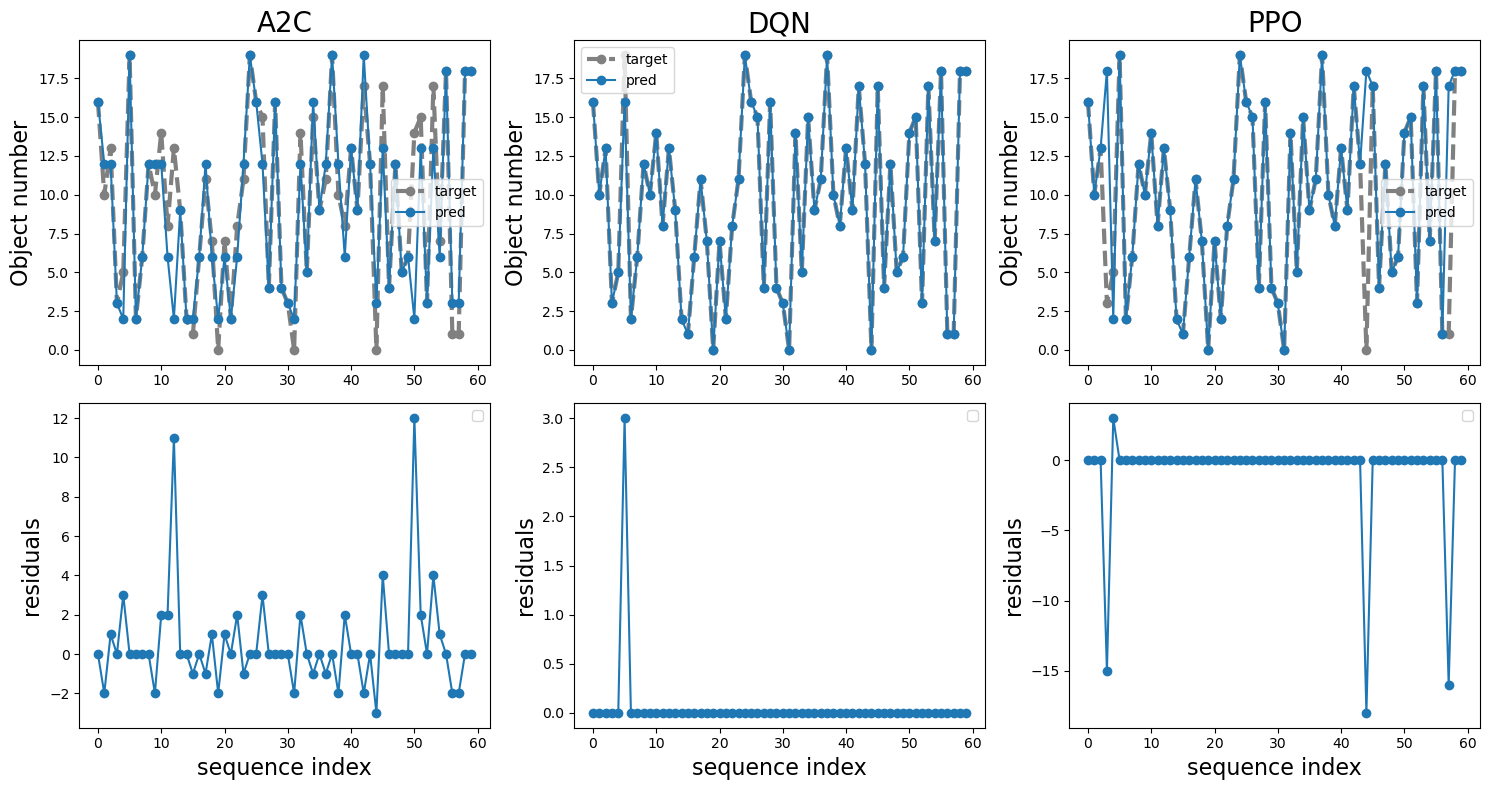

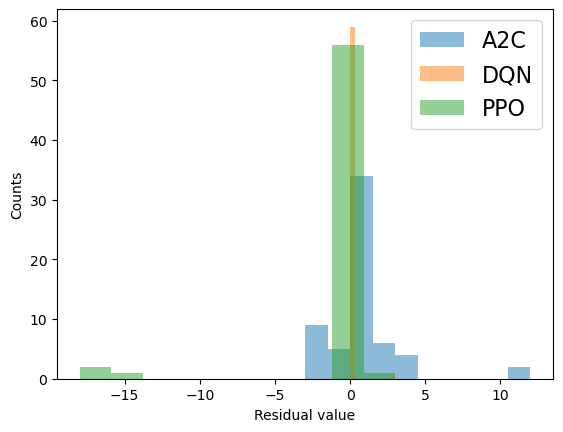

In [49]:
fig, axs = plt.subplots(2, 3, figsize=(15,8), sharex='row')
fig_hist, ax_hist = plt.subplots()
for i, model_name in enumerate(results.keys()):
    axs[0,i].set_title(model_name, fontsize=20)
    axs[0,i].plot(np.array(true_sequence), marker='o', label='target', color='grey', linestyle='dashed', lw=3)
    axs[0,i].plot(np.array(proposed_survey[i]), marker='o', label='pred')
    axs[0,i].legend()
    axs[0,i].set_ylabel('Object number', fontsize=16)

    residuals = np.array(true_sequence) - np.array(proposed_survey[i])
    axs[1,i].plot(residuals, marker='o')
    axs[1,i].legend()
    axs[1, i].set_xlabel('sequence index', fontsize=16)
    axs[1,i].set_ylabel('residuals', fontsize=16)
    
    ax_hist.hist(residuals, label=model_name, alpha=.5)
    ax_hist.set_xlabel('Residual value')
    ax_hist.set_ylabel('Counts')
    ax_hist.legend(fontsize=16)
fig.tight_layout()
    
# fig.savefig(OUTDIR + '')

In [50]:
n_episodes = 50
rewards = np.empty(shape=(len(true_sequence), n_episodes))
for i, model_name in enumerate(results.keys()):
    mean, std = evaluate_policy(results[model_name]['model'], Monitor(env), n_eval_episodes=n_episodes, deterministic=False)
    rewards[i], epsiodes = evaluate_policy(results[model_name]['model'], Monitor(env), n_eval_episodes=n_episodes, return_episode_rewards=True, deterministic=False)
    print(model_name, "mean =", f"{mean:.2f}", ', std = ', f"{std:.2f}")

A2C mean = 31.07 , std =  0.86
DQN mean = 55.04 , std =  1.39
PPO mean = 50.85 , std =  3.19


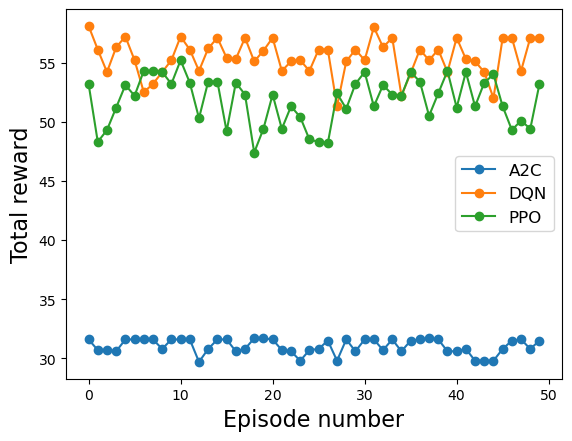

In [51]:
for i, model_name in enumerate(results.keys()):
    plt.plot(rewards[i], label=model_name, marker='o')
plt.xlabel('Episode number', fontsize=16)
plt.ylabel('Total reward', fontsize=16)
plt.legend(fontsize=12)